In [1]:
## Environnement matériel et logiciel
#Keras et tensorFlow s'installent simplement à partir de la distribution Anaconda de Python. 

In [2]:
# Utils
import sys
import os
import shutil
import time
import pickle
import numpy as np

# Deep Learning Librairies
import tensorflow as tf
import keras.preprocessing.image as kpi

import keras.layers as kl
import keras.optimizers as ko
import keras.backend as k
import keras.models as km
import keras.applications as ka

# Visualisaiton des données
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [3]:
## sanity check = verif GPU-OK

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8053941284986851707
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3633373324587016972
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1030792269277196199
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4980277248
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2182740084234834508
physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [5]:
MODE = "GPU" if "GPU" in [k.device_type for k in device_lib.list_local_devices()] else "CPU"
print(MODE)

GPU


In [6]:
data_dir = '/home/lepic/N7/mlpV2k/S2/' # chemin d'accès aux données
train = 297 
test = 55

In [7]:
train

297

In [8]:
test

55

In [9]:
### Illustration des données
# La fonction `load_img` permet de charger une image comme une image PIL.

In [10]:
# https://docs.python-guide.org/scenarios/imaging/

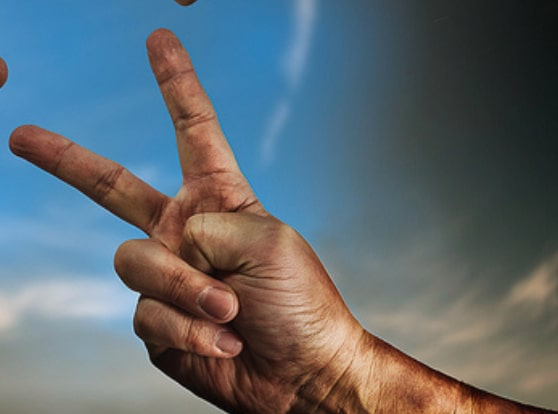

In [11]:
img = kpi.load_img(data_dir+'/train/scissors/Scissors.23.4.jpg')  # this is a PIL image
img

In [12]:
#La fonction `img_to_array` génére un `array numpy` a partir d'une image PIL .

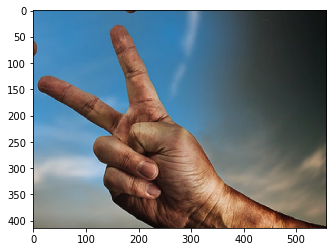

In [13]:
x = kpi.img_to_array(img)  
plt.imshow(x/255, interpolation='nearest')
plt.show()

In [14]:
# La fonction img_to_array génére un array numpy a partir d'une image PIL 
# pourquoi scikit learn travaille avec array numpy

In [15]:
### Pré-traitements
# Les images du jeu de données sont de dimensions différentes : 

In [16]:
x_0 = kpi.img_to_array(kpi.load_img(data_dir+"/train/scissors/Scissors.23.4.jpg"))
x_1 = kpi.img_to_array(kpi.load_img(data_dir+"/train/scissors/Scissors.25.01.jpg"))
x_0.shape, x_1.shape

((414, 558, 3), (3120, 4160, 3))

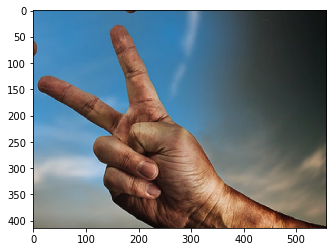

In [17]:
x = kpi.img_to_array(x_0)  
plt.imshow(x/255, interpolation='nearest')
plt.show()

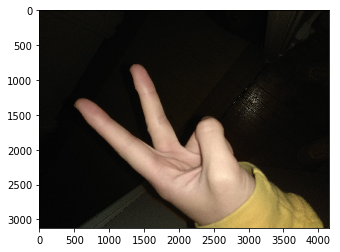

In [18]:
x = kpi.img_to_array(x_1)  
plt.imshow(x/255, interpolation='nearest')
plt.show()

In [19]:
img_width = 600 # var non utilisee
img_height = 600 # var non utilisee 

In [20]:
epochs = 4
batch_size=10

In [21]:
# 10 boucles
# taille des batchs == 1 epoque je passe en revue les 20 batchs

In [22]:
### Réseau convolutionnel
#Dans un premiers temps, on construit notre propre réseau de neurones convolutionnel.

In [23]:
# ITERATION 1
## attention == ici on pas fait de l'augmentation d'invidus simplement du rescale = 1./255


## this is the augmentation configuration we will use for training
train_datagen = kpi.ImageDataGenerator(
        rescale=1./255,
)

## this is the augmentation configuration we will use for testing:
##only rescaling
valid_datagen = kpi.ImageDataGenerator(rescale=1./255)

## this is a generator that will read pictures found in
## subfolers of 'data/train', and indefinitely generate
## batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        data_dir+"/train/",  # this is the target directory
        target_size=(img_width, img_height),  
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

## this is a similar generator, for validation data
validation_generator = valid_datagen.flow_from_directory(
        data_dir+"/test/",
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical')

Found 294 images belonging to 3 classes.
Found 52 images belonging to 3 classes.


In [24]:
# definition de notre modele

In [25]:
model_conv = km.Sequential()
model_conv.add(kl.Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), data_format="channels_last"))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Conv2D(32, (3, 3)))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Conv2D(64, (3, 3)))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_conv.add(kl.Dense(64))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.Dropout(0.5))
model_conv.add(kl.Dense(3))
model_conv.add(kl.Activation('softmax'))

model_conv.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 598, 598, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 598, 598, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 299, 299, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 297, 297, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 297, 297, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 146, 146, 64)      18496     
__________

In [26]:
ts = time.time()

model_conv.fit_generator(train_generator, steps_per_epoch=train // batch_size, epochs=epochs,
       validation_data=validation_generator,validation_steps=test // batch_size)

te = time.time()

t_learning_conv_simple_model = te-ts
print("Learning TIme for %d epochs : %d seconds"%(epochs,t_learning_conv_simple_model))

model_conv.save(data_dir+'/'+MODE+'_models_convolutional_network_%d_epochs_%d_batch_size.h5' %(epochs, batch_size))

Epoch 1/4
29/29 [==============================] - 59s 2s/step - loss: 4.5634 - acc: 0.3621 - val_loss: 1.2329 - val_acc: 0.3800
Epoch 2/4
29/29 [==============================] - 51s 2s/step - loss: 1.0498 - acc: 0.4329 - val_loss: 0.9844 - val_acc: 0.7381
Epoch 3/4
29/29 [==============================] - 49s 2s/step - loss: 0.7818 - acc: 0.6227 - val_loss: 0.7990 - val_acc: 0.7381
Epoch 4/4
29/29 [==============================] - 51s 2s/step - loss: 0.6385 - acc: 0.6967 - val_loss: 0.4535 - val_acc: 0.9286
Learning TIme for 4 epochs : 209 seconds


In [27]:
ts = time.time()

score_conv_val = model_conv.evaluate_generator(validation_generator, test /batch_size, verbose=1)

score_conv_train = model_conv.evaluate_generator(train_generator, train / batch_size, verbose=1)

te = time.time()

t_prediction_conv_simple_model = te-ts
print('Train accuracy:', score_conv_train[1])
print('Validation accuracy:', score_conv_val[1])
print("Time Prediction: %.2f seconds" %t_prediction_conv_simple_model )

30/29 [==============================] - 41s 1s/step
Train accuracy: 0.8605442148487584
Validation accuracy: 0.9038461423837222
Time Prediction: 52.54 seconds
